# HMM OF THE DISHONEST CASINO

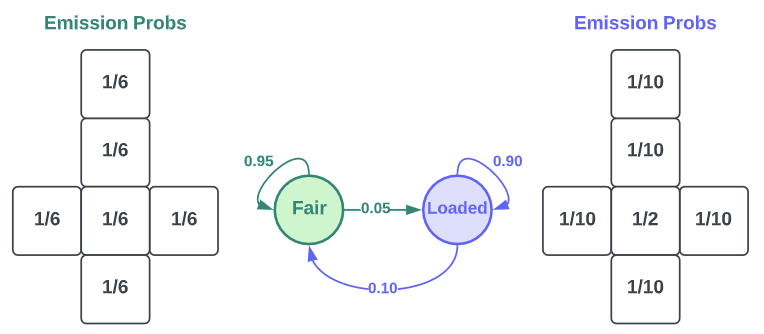

## Setup

In [ ]:
try:
    import dynamax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax
dynamax.__file__

'/Users/scott/Projects/dynamax/dynamax/__init__.py'

In [ ]:
try:
    import graphviz
except ModuleNotFoundError:
    %pip install graphviz

In [ ]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import optax

from graphviz import Digraph
import matplotlib.pyplot as plt

from dynamax.hmm.models import CategoricalHMM

# from dynamax.hmm.demos.casino_hmm import make_model_and_data

## Initilization

In [ ]:
num_states = 2
num_emissions = 1
num_classes = 6
num_batches = 4
num_timesteps = 5000
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

params = dict(
    initial=dict(probs=jnp.array([1, 1]) / 2),
    transitions=dict(transition_matrix=jnp.array([[0.95, 0.05], [0.10, 0.90]])),
    emissions=dict(
        probs=jnp.array(
            [
                [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
                [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],  # loaded die
            ]
        ).reshape(num_states, num_emissions, num_classes)
    ),
)

batch_states, batch_emissions = vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
    jr.split(jr.PRNGKey(0), num_batches)
)

## Learning

In [ ]:
num_epochs = 400
learning_rate = 1e-1
momentum = 0.95
optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum)
shuffle = True

### Full-Batch Gradient Descent

In [ ]:
key = jr.PRNGKey(1)
fbgd_params, fbgd_param_props = hmm.random_initialization(key)
fbgd_params, losses_fbgd = hmm.fit_sgd(
    fbgd_params,
    fbgd_param_props,
    batch_emissions,
    optimizer=optimizer,
    batch_size=num_batches,
    num_epochs=num_epochs,
    shuffle=shuffle,
    key=key,
)

### Mini-Batch Gradient Descent

In [ ]:
key = jr.PRNGKey(1)
mbgd_params, mbgd_param_props = hmm.random_initialization(key)
mbgd_params, losses_mbgd = hmm.fit_sgd(
    mbgd_params,
    mbgd_param_props,
    batch_emissions,
    optimizer=optimizer,
    batch_size=2,
    num_epochs=num_epochs,
    shuffle=shuffle,
    key=key,
)

### Stochastic Gradient Descent

In [ ]:
key = jr.PRNGKey(1)
sgd_params, sgd_param_props = hmm.random_initialization(key)
sgd_params, losses_sgd = hmm.fit_sgd(
    sgd_params,
    sgd_param_props,
    batch_emissions,
    optimizer=optimizer,
    batch_size=1,
    num_epochs=num_epochs,
    shuffle=shuffle,
    key=key,
)

### Expectation-Maximization

In [ ]:
key = jr.PRNGKey(1)
em_params, em_param_props = hmm.random_initialization(key)
em_params, losses_em = hmm.fit_em(em_params, em_param_props, batch_emissions, num_iters=num_epochs)
losses_em *= -1

100%|██████████| 400/400 [00:01<00:00, 272.88it/s]


## Results

In [ ]:
def hmm_plot_graphviz(trans_mat, obs_mat, states=[], observations=[]):
    """
    Visualizes HMM transition matrix and observation matrix using graphhiz.
    Parameters
    ----------
    trans_mat, obs_mat, init_dist: arrays
    states: List(num_hidden)
        Names of hidden states
    observations: List(num_obs)
        Names of observable events
    Returns
    -------
    dot object, that can be displayed in colab
    """

    n_states, _, n_obs = obs_mat.shape

    dot = Digraph(comment="HMM")
    if not states:
        states = [f"State {i + 1}" for i in range(n_states)]
    if not observations:
        observations = [f"Obs {i + 1}" for i in range(n_obs)]

    # Creates hidden state nodes
    for i, name in enumerate(states):
        table = [f'<TR><TD>{observations[j]}</TD><TD>{"%.2f" % prob}</TD></TR>' for j, prob in enumerate(obs_mat[i, 0])]
        label = f"""<<TABLE><TR><TD BGCOLOR="lightblue" COLSPAN="2">{name}</TD></TR>{''.join(table)}</TABLE>>"""
        dot.node(f"s{i}", label=label)

    # Writes transition probabilities
    for i in range(n_states):
        for j in range(n_states):
            dot.edge(f"s{i}", f"s{j}", label=str("%.2f" % trans_mat[i, j]))
    dot.attr(rankdir="LR")
    # dot.render(file_name, view=True)
    return dot

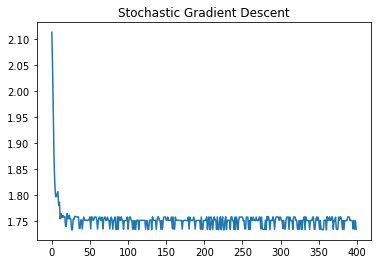

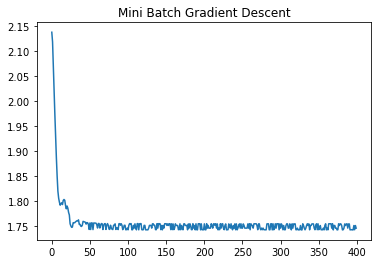

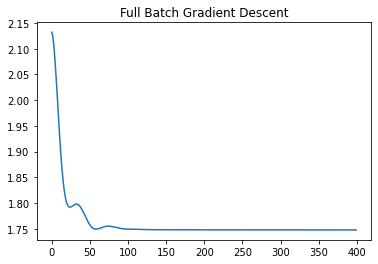

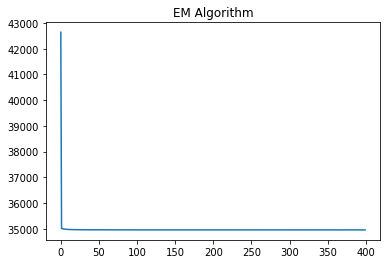

In [ ]:
losses = [losses_sgd, losses_mbgd, losses_fbgd, losses_em]

titles = ["Stochastic Gradient Descent", "Mini Batch Gradient Descent", "Full Batch Gradient Descent", "EM Algorithm"]

dict_figures = {}

for loss, title in zip(losses, titles):
    filename = title.replace(" ", "_").lower()
    fig, ax = plt.subplots()
    ax.plot(loss)
    ax.set_title(f"{title}")
    dict_figures[filename] = fig
    plt.savefig(f"{filename}.png", dpi=300)

plt.show()

In [ ]:
dotfile = hmm_plot_graphviz(sgd_params["transitions"]["transition_matrix"], sgd_params["emissions"]["probs"])
dotfile.render("hmm-casino-sgd-dot")

'hmm-casino-sgd-dot.pdf'

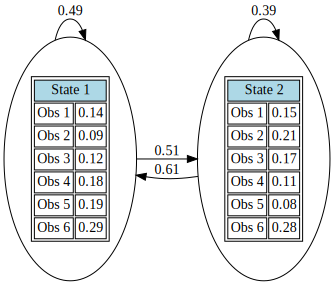

In [ ]:
dotfile

In [ ]:
dotfile = hmm_plot_graphviz(em_params["transitions"]["transition_matrix"], em_params["emissions"]["probs"])
dotfile.render("hmm-casino-em-dot")

'hmm-casino-em-dot.pdf'

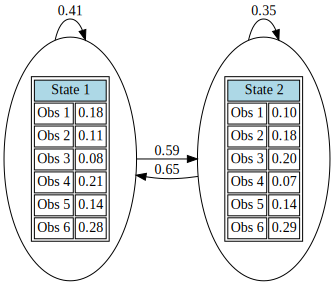

In [ ]:
dotfile